# Collaborative Filtering Algorithm
## Movie Recommemder System using Collaborative Filtering Algorithm
### This is an implementation of Collaborative Filtering Algorithm from scratch, based on the lecture of Andrew NG on the corresponding topic in Coursera.
### Dataset source: https://www.kaggle.com/grouplens/movielens-20m-dataset

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from textwrap import wrap

# Set default fontsize and colors for graphs
SMALL_SIZE, MEDIUM_SIZE, BIG_SIZE = 8, 12, 16
plt.rc('font', size=MEDIUM_SIZE)       
plt.rc('axes', titlesize=BIG_SIZE)     
plt.rc('axes', labelsize=MEDIUM_SIZE)  
plt.rc('xtick', labelsize=MEDIUM_SIZE) 
plt.rc('ytick', labelsize=MEDIUM_SIZE) 
plt.rc('legend', fontsize=SMALL_SIZE)  
plt.rc('figure', titlesize=BIG_SIZE)
my_colors = 'rgbkymc'

# Disable scrolling for long output
from IPython.display import display, Javascript
disable_js = """
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}
"""
display(Javascript(disable_js))

<IPython.core.display.Javascript object>

## (1) Read and Prepare Data

### Read "movie" and "rating" dataset

In [2]:
# Read the input training data
input_data_file_movie = "C:\Study\DataSets\movielens-20m-dataset\\movie.csv"
input_data_file_rating = "C:\Study\DataSets\movielens-20m-dataset\\rating.csv"

movie_data_all = pd.read_csv(input_data_file_movie)
rating_data_all = pd.read_csv(input_data_file_rating)

In [3]:
movie_data_all.head(5)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
rating_data_all.head(5)

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [5]:
print("Total number of movies =", movie_data_all.shape[0])
print("Total number of unique movies =", len(movie_data_all.movieId.unique()))
print("")
print("Total number of user ratings =", rating_data_all.shape[0])
print("Total number of unique users =", len(rating_data_all.userId.unique()))

Total number of movies = 27278
Total number of unique movies = 27278

Total number of user ratings = 20000263
Total number of unique users = 138493


In [6]:
# Keep only required columns
movie_data_all = movie_data_all.drop(['genres'], axis=1)
rating_data_all = rating_data_all.drop(['timestamp'], axis=1)

In [7]:
# Test with a subset of data

# Fetch num_movies number of movies
#num_movies = 10
#movie_data = movie_data_all.iloc[:num_movies, :]

# Fetch only ratings corresponding to above movies 
#rating_data = rating_data_all[rating_data_all.movieId.isin(movie_data.movieId)]

#print("Total number of movies to be used to training =", movie_data.shape[0])
#print("Total number of user ratings to be used for training =", rating_data.shape[0])

In [8]:
# Test with a subset of data
#num_movies = 500
#num_ratings = 10000
#movie_data = movie_data.iloc[:num_movies, :]
#rating_data = rating_data.iloc[:num_ratings, :]

### Select few most popular movies, from two distinct genres. In this particular example, we considered movies of genres "Action" and "Romance".
### The objective is to find if collborative filtering algorithm can successfully learn the features of these movies based on user ratings, such that we can clearly distinguish their genres and recommend accordingly.

In [9]:
# Pick top movies
top_action_movies = ['Dark Knight, The', 'Lord of the Rings: The Return of the King', 
                     'Inception', 'Star Wars: Episode V - The Empire Strikes Back',
                     'Matrix, The']
top_romantic_movies = ['Notting Hill', 'Love Story \(1970\)', 'When Harry Met Sally',
                       'Titanic \(1997\)', 'Pretty Woman']
top_movies = top_action_movies + top_romantic_movies

movie_data = movie_data_all[movie_data_all.title.str.contains('|'.join(top_movies))]
movie_data

,movieId,title
591,597,Pretty Woman (1990)
1171,1196,Star Wars: Episode V - The Empire Strikes Back...
1278,1307,When Harry Met Sally... (1989)
1661,1721,Titanic (1997)
2486,2571,"Matrix, The (1999)"
2585,2671,Notting Hill (1999)
4201,4296,Love Story (1970)
7041,7153,"Lord of the Rings: The Return of the King, The..."
12525,58559,"Dark Knight, The (2008)"
15534,79132,Inception (2010)


In [10]:
# Pick all ratings
#num_ratings = 2000000
rating_data = rating_data_all.iloc[:, :]

### Merge movie and rating dataset based on movieId column

In [11]:
movie_rating_merged_data = movie_data.merge(rating_data, on='movieId', how='inner')
movie_rating_merged_data.head()

,movieId,title,userId,rating
0,597,Pretty Woman (1990),7,4.0
1,597,Pretty Woman (1990),8,5.0
2,597,Pretty Woman (1990),11,4.5
3,597,Pretty Woman (1990),13,5.0
4,597,Pretty Woman (1990),24,3.0


In [12]:
# Mean rating of a movie
movie_rating_merged_data[movie_rating_merged_data.title == 'Pretty Woman (1990)']['rating'].mean()

3.420427728613569

In [13]:
# Top 10 movies by mean rating
movie_rating_merged_data.groupby(['title'], sort=False)['rating'].mean().sort_values(ascending=False).head(10)

title
Dark Knight, The (2008)                                  4.220129
Star Wars: Episode V - The Empire Strikes Back (1980)    4.188202
Matrix, The (1999)                                       4.187186
Inception (2010)                                         4.156172
Lord of the Rings: The Return of the King, The (2003)    4.142382
When Harry Met Sally... (1989)                           3.842996
Notting Hill (1999)                                      3.453924
Pretty Woman (1990)                                      3.420428
Titanic (1997)                                           3.338188
Love Story (1970)                                        3.173618
Name: rating, dtype: float64

## (2) Build Collaborative Filtering Model

### Create a pivot table of movies (on rows) and corresponsing user ratings (on columns). The pivot table will contain the ratings of only selected movies.
### Thus, rows = movies and columns = users

In [14]:
movie_rating_merged_pivot = pd.pivot_table(movie_rating_merged_data,
                                           index=['title'],
                                           columns=['userId'],
                                           values=['rating'],
                                           dropna=False,
                                           fill_value=0
                                          )
movie_rating_merged_pivot.shape

(10, 94160)

In [15]:
Y = movie_rating_merged_pivot

### Create a matrix R, such that, R(i,j) = 1 iff User j has selected a rating for Movie i. R(i,j) = 0 otherwise.

In [16]:
R = np.ones(Y.shape)
no_rating_idx = np.where(Y == 0.0)
R[no_rating_idx] = 0
R

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 1.],
       ...,
       [1., 1., 1., ..., 0., 1., 1.],
       [0., 0., 1., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 1., 0.]])

### Assign n_m (number of movies), n_u (number of users) and n_f (number of features)

In [17]:
n_u = Y.shape[1]
n_m = Y.shape[0]
n_f = 2

### Assign random initial values to movie and user parameters.
### X = parameters of movies (each row represent a movie)
### Theta = parameters of users (each row represent a user)

In [18]:
Initial_X = np.random.rand(n_m, n_f)
Initial_Theta = np.random.rand(n_u, n_f)
#print("Initial_X =", Initial_X)
#print("Initial_Theta =", Initial_Theta)

### Cost function or Objective function of collborative filtering algorithm

In [19]:
# Cost Function
def collabFilterCostFunction(X, Theta, Y, R, reg_lambda):
    cost = 0
    error = (np.dot(X, Theta.T) - Y) * R
    error_sq = np.power(error, 2)
    cost = np.sum(np.sum(error_sq)) / 2
    cost = cost + (reg_lambda/2) * ( np.sum(np.sum((np.power(X, 2)))) 
                                    + np.sum(np.sum((np.power(Theta, 2)))) )
    return cost

### Computation of Gradient Descent of collaborative filtering algorithm

In [20]:
# Gradient Descent
def collabFilterGradientDescent(X, Theta, Y, R, alpha, reg_lambda, num_iters):
    cost_history = np.zeros([num_iters, 1])
    
    for i in range(num_iters):
        error = (np.dot(X, Theta.T) - Y) * R
        X_grad = np.dot(error, Theta) + reg_lambda * X
        Theta_grad = np.dot(error.T, X) + reg_lambda * Theta
        
        X = X - alpha * X_grad 
        Theta = Theta - alpha * Theta_grad
        
        cost_history[i] = collabFilterCostFunction(X, Theta, Y, R, reg_lambda)
        
    return X, Theta, cost_history

## (3) Train the collborative filtering model

In [21]:
# Tune hyperparameters
alpha = 0.0001
num_iters = 25000
reg_lambda = 0

# Perform gradient descent to find optimal parameters
X, Theta = Initial_X, Initial_Theta
X, Theta, cost_history = collabFilterGradientDescent(X, Theta, Y, R, alpha, reg_lambda, num_iters)
cost = collabFilterCostFunction(X, Theta, Y, R, reg_lambda)
print("Find cost =", cost)

Find cost = 29810.756341445544


### Plot cost vs number of iterations

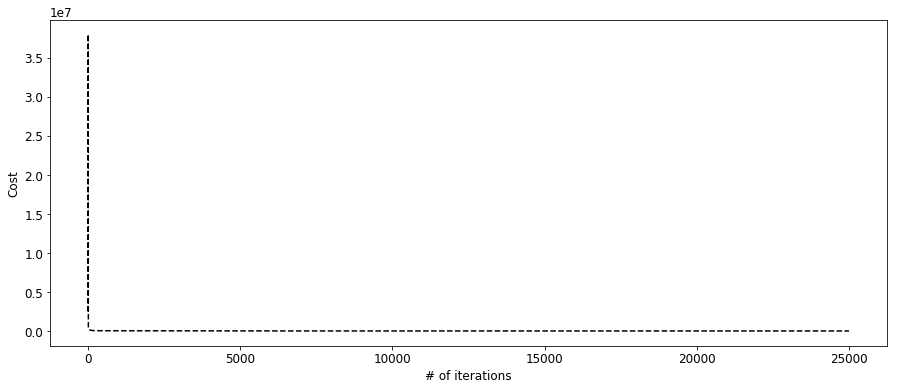

In [22]:
fig, axes = plt.subplots(figsize=(15,6))
axes.plot(cost_history, 'k--')
axes.set_xlabel('# of iterations')
axes.set_ylabel('Cost')
plt.show()

### Since we have considered only 2 genres (and hence 2 features), we plot the learned feature parameters of movies to visualize the pattern.
### We find below that the algorithm has learnt the features pretty well and hence the movies of same genre and clustered together. 
### In this particular example, we considered movies of genres "Action" and "Romance". From the visualization, it can be concluded that X-axis represents "Degree of Action" and Y-axis represents "Degree of Romance".
### As a next step, we can run K-Means clustering to further verify our understanding.

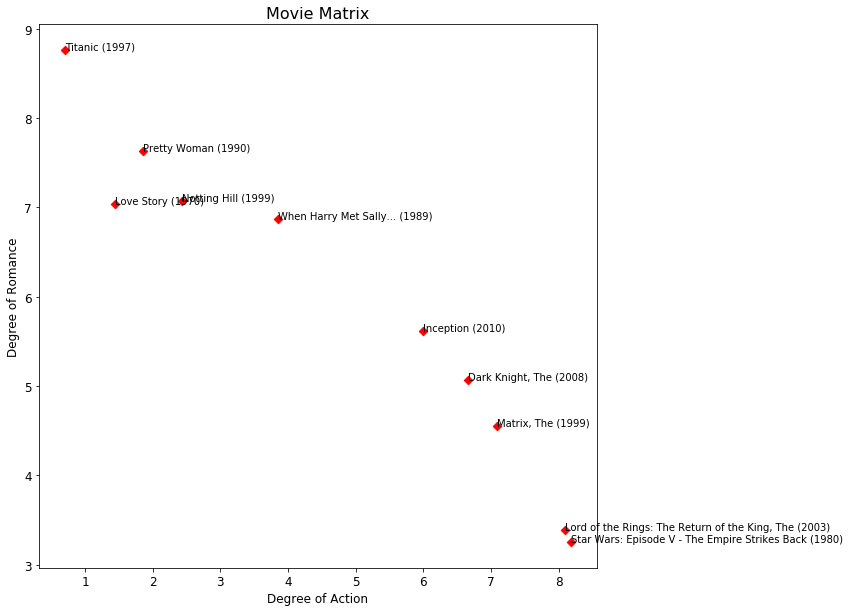

In [43]:
fig, axes = plt.subplots(figsize=(10,10))
axes.scatter(X[:,0], X[:,1], color='red', marker='D')

for val, movie in zip(X, Y.index):
    axes.text(val[0], val[1], movie)

axes.set_xlabel('Degree of Action')
axes.set_ylabel('Degree of Romance')
axes.set_title('Movie Matrix')

plt.show()

### For a random user, what are her preferred movies, and what is our recommendation for her based on result of collaborative filtering algorithm?

In [42]:
user_idx = np.random.randint(n_u)
pred_rating = []
print("Original rating of an user:\n", Y.iloc[:,user_idx].sort_values(ascending=False))

predicted_ratings = np.dot(X, Theta.T)
predicted_ratings = sorted(zip(predicted_ratings[:,user_idx], Y.index), reverse=True)
print("\nPredicted rating of the same user:")
_ = [print(rating, movie) for rating, movie in predicted_ratings]

Original rating of an user:
 title
Titanic (1997)                                           5.0
Pretty Woman (1990)                                      4.5
Dark Knight, The (2008)                                  4.5
Matrix, The (1999)                                       4.0
When Harry Met Sally... (1989)                           0.0
Star Wars: Episode V - The Empire Strikes Back (1980)    0.0
Notting Hill (1999)                                      0.0
Love Story (1970)                                        0.0
Lord of the Rings: The Return of the King, The (2003)    0.0
Inception (2010)                                         0.0
Name: (rating, 75212), dtype: float64

Predicted rating of the same user:
4.949419178469805 Titanic (1997)
4.648944602401086 When Harry Met Sally... (1989)
4.6011962815762955 Pretty Woman (1990)
4.466691303353013 Inception (2010)
4.428913739067579 Notting Hill (1999)
4.319574539395297 Dark Knight, The (2008)
4.182461804852902 Love Story (1970)
4.1411611